In [ ]:
# default_exp model_evaluation

# Model Evaluation 📈

In [ ]:
#export
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score,precision_recall_curve
from funcsigs import signature
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def show_loss_accurracy_plots(history):
    """Displays loss and accuracy plots for the input model history"""
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs2 = range(len(acc))

    plt.plot(epochs2, acc, 'b', label='Training')
    plt.plot(epochs2, val_acc, 'r', label='Validation')
    plt.title('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend()

    plt.figure()

    plt.plot(epochs2, loss, 'b', label='Training')
    plt.plot(epochs2, val_loss, 'r', label='Validation')
    plt.title('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()

    plt.show()

## Loss Accuracy Plots
We want to see if we reach criticality

In [ ]:
history = pd.read_csv('../08_test/history_training.csv')
show_loss_accurracy_plots(history)

FileNotFoundError: [Errno 2] No such file or directory: '../08_test/history_training.csv'

In [ ]:
# filepath changed from: 'alex-adapted-res-003/best_model.hdf5' for testing
path = '../08_test/best_model.hdf5'
# You must be using tensorflow 2.3 or greater
criticality_network_load = load_model(path) #<----- The Model

In [ ]:
corpora_test_x = np.load('../08_test/corpora_test_x.npy')
target_test_y = np.load('../08_test/target_test_y.npy')

In [ ]:
#export
def evaluate_model(criticality_network_load,corpora_test_x,target_test_y):
    """Displays the given model's: loss, accuracy, Average prcision-recall and AUC for the given data."""
    score = criticality_network_load.evaluate(corpora_test_x, target_test_y, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    history_predict = criticality_network_load.predict(x=corpora_test_x)
    history_predict
    
    inferred_data = pd.DataFrame(history_predict,columns=list('AB'))
    target_data = pd.DataFrame(target_test_y,columns=list('LN'))
    data = target_data.join(inferred_data)
    
    y_true = list(data['L'])
    y_score= list(data['A'])
    average_precision = average_precision_score(y_true, y_score)
    
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    
    #ROC Curve (all our samples are balanced)
    auc = roc_auc_score(y_true, y_score)
    print('AUC: %.3f' % auc)

## Get Accuracy of Model

In [ ]:
evaluate_model(criticality_network_load,corpora_test_x,target_test_y)

361/361 [==============================] - 4s 10ms/step - loss: 0.3210 - accuracy: 0.9616
Test loss: 0.3209781050682068
Test accuracy: 0.9616250991821289
Average precision-recall score: 0.99
AUC: 0.988


In [ ]:
def clean_list(inp):
    out = []
    for i in inp:
        out.append(i[0])
    return out

def clean_input(inp):
    return tuple(clean_list(inp.tolist()))


In [ ]:
def summarize(inp):
    total = 0
    for i in inp:
        # print(i)
        total+=i
    new = [total]
    return new

# Shap Evaluations

In [ ]:
from securereqnet.utils import Embeddings
import shap
model = criticality_network_load

## Get Reverse Embeddings Mapping

In [ ]:
embeddings = Embeddings()
embed_path = '../data/word_embeddings-embed_size_100-epochs_100.csv'
embeddings_dict = embeddings.get_embeddings_dict(embed_path)
reverse_embeddings = {}

for key, value in embeddings_dict.items():
    value = tuple(np.array(value, dtype='float32').tolist())
    # print(value)
    reverse_embeddings[value] = key


## Calculate Shap Values for 200 Images
We need a background of 400 to calculate these 200 points over

In [ ]:
# select a set of background examples to take an expectation over
background = corpora_test_x[np.random.choice(corpora_test_x.shape[0], 400, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(corpora_test_x[0:200])

keras is no longer supported, please use tf.keras instead.


Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Map Shap Values to Tokens
Using our reversed embeddings from earlier, we essentially undo the vectorization so we can map shap values to our tokens.  Tokens are much more readable than vectors, and allow for easy human interpretation.

In [ ]:
# map shap values to strings
# (shap, string)
shaps = []

for doc in range(shap_values[0].shape[0]):
    for word in range(shap_values[0][doc].shape[0]):
        # grab the word
        try:
            string = reverse_embeddings[clean_input(corpora_test_x[doc, word])]
            shap_value = summarize(clean_list(shap_values[0][doc, word]))[0]
            shaps.append((shap_value, string))
        except KeyError as e:
            pass
shaps = sorted(shaps, key = lambda x: abs(x[0]), reverse=True)

## Create Plot
Here we plot the top 25 shap values over the 200 data points and check their effects

<Figure size 432x288 with 0 Axes>

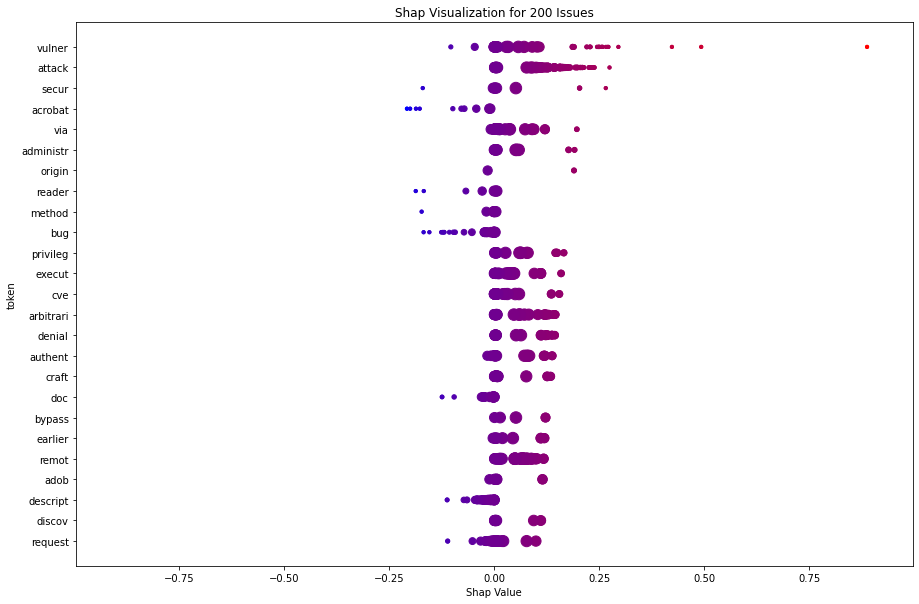

In [ ]:
import matplotlib.pyplot as plt
import math
import statistics
shap_vals = [] 
token = []
fig1 = plt.gcf()

data = {}

# Top 25 shap vals
uBound = 25
i = 0
while i < uBound:
    if(i < len(shaps)):
        curTok = shaps[i][1]
        curShap = shaps[i][0]
        if curTok in data.keys():
            data[curTok].append(curShap)
            uBound += 1
        else:
            data[curTok] = [curShap]
    i += 1

# get the rest
for i in range(len(shaps)):
    curTok = shaps[i][1]
    curShap = shaps[i][0]
    if curTok in data.keys():
        data[curTok].append(curShap)

for key in data.keys():
    for item in data[key]:
        shap_vals.append(item)
        token.append(key)
    
fig = plt.figure(figsize = (15, 10)) 

max_shap_val = max(shap_vals)
min_shap_val = min(shap_vals)
total_range = max_shap_val - min_shap_val
std_dev = statistics.stdev(shap_vals)
median = statistics.median(shap_vals)
mean = statistics.mean(shap_vals)

# define our gradient
# we want something less linear
redness = lambda x : math.sqrt(((x+abs(min_shap_val))/total_range) * 100) * 10 / 100
blueness = lambda x : 1 - redness(x)

# size as normal distribution 
size = lambda x : 500 * math.ceil(100 * ((1/(std_dev*math.sqrt(math.pi))*math.e)**(-1*((x-mean)**2)/(2*std_dev**2)))) / 100 + 35

plt.xlabel("Shap Value") 
plt.ylabel("token") 
plt.title("Shap Visualization for 200 Issues") 
plt.xlim([-1 * (max_shap_val + std_dev), max_shap_val + std_dev])
plt.gca().invert_yaxis()
# creating the bar plot 
plt.scatter(shap_vals, token, c = [(redness(x), 0, blueness(x)) for x in shap_vals], marker='.', s = [size(x) for x in shap_vals]) 
plt.savefig("../images/shap_200_issues_alpha.png", transparent=False)
plt.show()